# Importation:

In [1]:
import pandas as pd
import numpy as np
import re
from unicodedata import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Cleaning:

## Lecture et information sur les données:

In [2]:
df1 = pd.read_csv('indeed_mongo.csv')
df = pd.read_csv('indeed.pre_processing.csv')

In [6]:
df.shape

(8140, 232)

In [74]:
len(df)

8140

In [69]:
df['localisation'].head()

0    Toulouse
1    Toulouse
2    Toulouse
3    Toulouse
4    Toulouse
Name: localisation, dtype: object

In [70]:
df['adresse'].head()

0    Toulouse (31)
1    Toulouse (31)
2      Labège (31)
3    Toulouse (31)
4    Toulouse (31)
Name: adresse, dtype: object

In [83]:
centre = [1 if (df['localisation'][i] in df['adresse'][i]) else 0 for i in range(len(df))]
len(centre)
df['centre'] = centre
df['centre']

0       1
1       1
2       0
3       1
4       1
5       1
6       1
7       1
8       0
9       1
10      0
11      1
12      1
13      1
14      0
15      1
16      0
17      1
18      1
19      1
20      1
21      1
22      0
23      1
24      1
25      0
26      1
27      1
28      1
29      1
       ..
8110    1
8111    1
8112    1
8113    1
8114    0
8115    0
8116    0
8117    0
8118    0
8119    0
8120    0
8121    1
8122    0
8123    1
8124    0
8125    0
8126    1
8127    1
8128    0
8129    1
8130    0
8131    0
8132    1
8133    0
8134    1
8135    0
8136    0
8137    0
8138    1
8139    0
Name: centre, Length: 8140, dtype: int64

In [9]:
pd.isna(df).sum(axis = 0)

_id                          0
adresse                      0
date_de_publication        245
description                  0
localisation                 0
nom_entreprise              13
salaire                   6318
titre                        0
url                          0
salaire_moyen             6318
niveau_etude              3843
type_de_cursus            7730
type_de_contrat           4186
grande_categorie          7493
bac + 1                      0
bac + 2                      0
bac + 3                      0
bac + 4                      0
bac + 5                      0
diplôme supérieur            0
ingénieur                    0
master 1                     0
master 2                     0
autodidacte                  0
ecole ingénieur              0
grande école                 0
ingénieur informatique       0
école de commerce            0
école ingénieur              0
3 mois renouvelable          0
                          ... 
vbscript                     0
joule   

## Fonction qui calcule le salaire moyen:

In [3]:
def salary_man(df):
    salaire_moyen = []
    for i in range(len(df)):
        try:
            salaire_liste = re.findall('(\d+),?',normalize('NFKD',df['salaire'][i]).replace(' ',''))
            mois = re.search('mois',df['salaire'][i])
            jour = re.search('jour',df['salaire'][i])
            heure = re.search('heure',df['salaire'][i])
            if mois:
                if len(salaire_liste) > 1:
                    moy = 12 * (int(salaire_liste[0]) + int(salaire_liste[1])) / 2
                    salaire_moyen.append(moy)
                else:
                    salaire_moyen.append(int(salaire_liste[0]) * 12)
            elif jour:
                # Le nombre de jours travaillés maximum retenu sur la période de référence est de 261 jours.
                if len(salaire_liste) > 1:
                    moy = 261 * (int(salaire_liste[0]) + int(salaire_liste[1])) / 2
                    salaire_moyen.append(moy)
                else:
                    salaire_moyen.append(int(salaire_liste[0]) * 261)
            elif heure:
                # 1600 heures travaillées par an.
                if len(salaire_liste) > 1:
                    moy = (int(salaire_liste[0]) + int(salaire_liste[1])) / 2
                    if moy < 20:
                    #grande chance que le salaire soit exprimé en fait en k euros:
                        salaire_moyen.append(moy * 1600)
                    else:
                        salaire_moyen.append(moy * 1000)
                else:
                    if int(salaire_liste[0]) < 20:
                        salaire_moyen.append(int(salaire_liste[0]) * 1600)
                    else:
                        salaire_moyen.append(int(salaire_liste[0]) * 1000)
            else:
                if len(salaire_liste) > 1:
                    moy = (int(salaire_liste[0]) + int(salaire_liste[1])) / 2
                    salaire_moyen.append(moy)
                else:
                    salaire_moyen.append(int(salaire_liste[0]))
                    
        except:
            salaire_moyen.append('None')
            continue
    return salaire_moyen

salaire_moyen = salary_man(df)

#df.insert(6, "salaire_moyen", salaire_moyen, True)
df['salaire_moyen'] = salaire_moyen

In [27]:
hist_salaire = df['salaire_moyen'][df['salaire_moyen'] != 'None']
#plt.hist(hist_salaire.values.astype(np.float).reshape(-1,1), bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,10000])
#hist_salaire.values.astype(np.float).reshape(-1,1)
(hist_salaire['salaire_moyen']).dtype

KeyError: 'salaire_moyen'

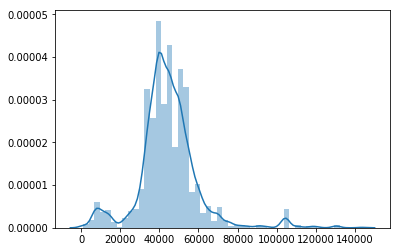

In [23]:
import seaborn as sns
hist_salaire = df[df['salaire_moyen'] != 'None']
sns.distplot(a = list(hist_salaire['salaire_moyen'].values))

In [22]:
list(hist_salaire['salaire_moyen'].values)

[32000.0,
 6600,
 42500.0,
 40000.0,
 43500.0,
 37000.0,
 50000.0,
 37000.0,
 35000.0,
 52500.0,
 42500.0,
 45000.0,
 48000,
 58000,
 15007.5,
 1320,
 52500.0,
 75000.0,
 52500.0,
 50000,
 70000,
 1320,
 42500.0,
 45000.0,
 50000.0,
 52500.0,
 40500.0,
 42000,
 39000.0,
 37000,
 38500.0,
 38500.0,
 50000,
 40000.0,
 36000.0,
 30000,
 35000,
 6960,
 37000,
 35000.0,
 35000.0,
 104400.0,
 35000.0,
 41000.0,
 40000,
 47500.0,
 39500.0,
 6612,
 38000.0,
 45000.0,
 45000,
 30000.0,
 40000.0,
 42000,
 58000,
 29000,
 60000,
 37500.0,
 35000,
 60000,
 30000,
 50000,
 33000.0,
 39000.0,
 54000,
 36000.0,
 57500.0,
 47500.0,
 55000.0,
 55000,
 34500.0,
 8700.0,
 31500.0,
 27000,
 40000,
 60000,
 15600,
 37500.0,
 104400.0,
 48000,
 40000.0,
 65000,
 40000.0,
 40000.0,
 40000.0,
 46000.0,
 45000,
 37500.0,
 55000.0,
 50000,
 47500.0,
 42000,
 52500.0,
 47000,
 55000.0,
 43000.0,
 60000.0,
 57500.0,
 143550,
 50000,
 41000,
 36000.0,
 45000,
 35000.0,
 50000,
 47500.0,
 52500.0,
 50000.0,
 36000,

In [5]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)
    Plot a histogram.
    
    Compute and draw the histogram of *x*. The return value is a
    tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
    [*patches0*, *patches1*,...]) if the input contains multiple
    data.
    
    Multiple data can be provided via *x* as a list of datasets
    of potentially different length ([*x0*, *x1*, ...]), or as
    a 2-D ndarray in which each column is a dataset.  Note that
    the ndarray form is transposed relative to the list form.
    
    Masked arrays are not supported at present.
    
    Parameters
    ----------
    x : (n,) array or sequence of (n,) arrays
        Input values, this takes either a single array or a sequence of
        

In [8]:
print(df.iloc[78,:][8])

https://www.indeed.fr/rc/clk?jk=7f3018b7409c5739&fccid=5e50810dc475b1eb&vjs=3


In [12]:
regex = df[['description','type_de_contrat']]

In [13]:
regex.head()

,description,type_de_contrat
0,"VIDAL ASSOCIATES Consulting & Search, référenc...",cdi
1,"Chez notre client grand compte, basé à Toulous...",cdi
2,Startup de l’IoT Valley labellisée Pass French...,NaN
3,L’equipe SRE est responsable de la disponibili...,NaN
4,WiSEED est un des acteurs les plus innovants e...,cdi


In [14]:
print(df['description'][2])

Startup de l’IoT Valley labellisée Pass French French Tech’, créée en 2012 par 4 ingénieurs, Cenareo développe un CMS (Content Management System) dédié à l'affichage dynamique. Intuitive et collaborative, la plateforme SaaS permet de créer, gérer et diffuser des contenus sur des écrans d'affichage en temps réel, à partir de n’importe quel PC, tablette ou smartphone.
En hyper croissance depuis sa création, Cenareo vient d’ouvrir son premier bureau hors de France, à Munich.
Avec des ambitions internationales affirmées, elle accueille les candidats multiculturels et étrangers. L’anglais devient la première langue parlée dans l’entreprise.

Cenareo emploie plus de 35 personnes en phase avec cette orientation qui renforce les valeurs de l’entreprise :
Satisfaction Client
Excellence Produit
Audace & Ambition
Inventivité
Esprits d’équipe

L'équipe :
Vous rejoindrez une équipe de passionnés par les nouvelles technologies, la vidéo et le billard ! Créative et portée par les challenges, l’équipe

In [15]:
contrat = ['cdi', 'cdd', 'stage', 'alternance', 'freelance']
data = []
for i in range(len(df)):
    inside_data = []
    for ele in contrat:
        pattern = re.compile(r"[\s/\(\),.]"+ele+r"[\s/\(\),.]")
        value = pattern.search(df['description'][i].lower().replace('\n',' ').replace('\r',' '))
        if value:
            inside_data.append(1)
        else:
            inside_data.append(0)
    data.append(inside_data)

desc = titre = [ele+'_desc' for ele in contrat]
contrat_desc = pd.DataFrame(data, columns=desc)
contrat_desc.sum()

cdi_desc           2538
cdd_desc            157
stage_desc          799
alternance_desc     232
freelance_desc      144
dtype: int64

In [16]:
contrat_desc[contrat_desc['freelance_desc'] == 1]

,cdi_desc,cdd_desc,stage_desc,alternance_desc,freelance_desc
49,1,0,0,0,1
116,1,0,0,0,1
177,0,0,0,0,1
200,1,0,0,0,1
245,1,0,0,0,1
256,1,0,0,0,1
284,1,0,0,0,1
335,0,0,0,0,1
343,1,0,0,0,1
358,1,0,0,0,1


In [17]:
contrat = ['cdi', 'cdd', 'stage', 'alternance', 'freelance']
data = []
for i in range(len(df)):
    inside_data = []
    for ele in contrat:
        pattern = re.compile(r"[\s/\(\),.]"+ele+r"[\s/\(\),.]?")
        value = pattern.search(df['titre'][i].lower().replace('\n',' ').replace('\r',' '))
        if value:
            inside_data.append(1)
        else:
            inside_data.append(0)
    data.append(inside_data)
titre = [ele+'_titre' for ele in contrat]
contrat_titre = pd.DataFrame(data, columns=titre)
contrat_titre.sum()

cdi_titre           121
cdd_titre            17
stage_titre          84
alternance_titre     55
freelance_titre     282
dtype: int64

In [18]:
contrat_titre[contrat_titre['freelance_titre'] == 1]

,cdi_titre,cdd_titre,stage_titre,alternance_titre,freelance_titre
69,0,0,0,0,1
88,0,0,0,0,1
122,0,0,0,0,1
125,0,0,0,0,1
128,0,0,0,0,1
140,0,0,0,0,1
158,0,0,0,0,1
206,0,0,0,0,1
262,0,0,0,0,1
323,0,0,0,0,1


In [19]:
liste_langage = ['python', 'r','vba', 'mysql','excel','asp.net','nosql','sql','linux','mongodb',
            'mariadb','java','javascript','php','html','css','sas','c#','ruby','swift','objective-c',
            'vb.net','kotlin','scala','bash','powershell','shell','front end','back end','soap',
            'dasl', 'pict', 'rexx', 'd', 'asp.net', 'f#', 'joy', 'sr', 'back end', 'poplog', 
            'modula-2', 'powershell', 'bash', 'concurrent pascal', 'apl', 'eiffel', 'lisp', 
            'cilk', 'c', 'awk', 'charity', 'bliss', 'spin', 'swift', 'visual basic', 'game maker language',
            'lisaac', 'xl', 'nosql', 'limbo', 'e', 'lava', 'slate', 'revolution', 'coldfusion', 
            'matlab', 'vb.net', 'cobol', 'tcl', 'rpg', 'sas', 'curl', 'front end', 'nemerle', 'f-script', 
            'xml', 's-lang', 'curry', 'basic', 'autoit', 'prolog', 'erlang', 'maya embedded language', 
            'frink', 'oz', 'windows powershell', 'beta', 'moo', 'object-z', 'self', 'leda', 'fortran', 
            'smalltalk', 'afnix', 'mysql', 'm', 'turing', 'jovial', 'lua', 'mondrian', 'io', 'salsa', 
            'kotlin', 'css', 'xotcl', 'perl', 'component pascal', 'mongodb', 'xhtml', 'dibol', 'oberon',
            'ada', 'visual foxpro', 'clist', 'pl/c', 'algol', 'mariadb', 'sql', 'pliant', 'excel', 
            'cobra', 'occam', 'obliq', 'prograph', 'chuck', 'pl/i', 'hypertalk', 'forth', 'ici', 
            'vba', 'beanshell', 'sgml', 'soap', 'opal', 'small', 'pascal', 'applescript', 'roop', 
            'agora', 'moto', 'rapira', 'alf', 'r', 'ml', 'javascript', 'pcastl', 'abcl', 'postscript', 
            'oxygene', 'cecil', 'clean', 'ops5', 'c\\+\\+', 'shell', 'haskell', 'kite', 'cleo', 'q', 'linux', 
                'vbscript', 'joule', 'rebol', 'jass', 'j', 'fril']

liste_outils = ['tableau', 'powerbi','symfony', 'jquery','angular','react','react native','node js','git','github',
            'visual studio','django','flask','api rest','laravel', 'hololens', 'docker', 'jira', 'scrum', 'kanban', 
               'azure','aws', 'teamcity', 'jenkins']

lieu = pd.get_dummies(df['localisation']).drop(['Bordeaux'], axis = 1)
langage = df[liste_langage]
outils = df[liste_outils]
for ele in liste_langage:
    if liste_langage.count(ele)>1:
        print(ele)

r
vba
mysql
excel
asp.net
nosql
sql
linux
mongodb
mariadb
javascript
css
sas
swift
vb.net
kotlin
bash
powershell
shell
front end
back end
soap
asp.net
back end
powershell
bash
swift
nosql
vb.net
sas
front end
mysql
kotlin
css
mongodb
mariadb
sql
excel
vba
soap
r
javascript
shell
linux


In [20]:
X_Y = pd.concat([lieu, langage, outils, contrat_titre, contrat_desc,df['salaire_moyen']],axis = 1)
X_Y.shape

(8140, 204)

In [21]:
(X_Y['salaire_moyen'] != 'None').sum()

1822

In [22]:
Y = X_Y['salaire_moyen'][X_Y['salaire_moyen'] != 'None']
X = X_Y[X_Y['salaire_moyen'] != 'None'].drop(['salaire_moyen'], axis = 1)

In [23]:
X.head()

,Lyon,Nantes,Paris,Toulouse,python,r,vba,mysql,excel,asp.net,...,cdi_titre,cdd_titre,stage_titre,alternance_titre,freelance_titre,cdi_desc,cdd_desc,stage_desc,alternance_desc,freelance_desc
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
20,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


# Grid search:

In [24]:
X_train, X_test, y_trainy, y_testy = train_test_split(X,Y , test_size=0.25, random_state=0)

In [25]:
y_trainy

5360      50000
3691      40000
7706      47500
949       47000
2210      42000
5149      47500
3997      45000
4811      41500
3825      38500
4379      47000
3276      47000
8095      30000
6559      18000
19        42500
6346      40000
6965      57000
2260      60000
4998      65000
4710      45000
5641     117450
1646      32000
5519      37000
6681      45000
951       50000
7309      45000
3929      52500
1890      50000
2242      50000
7085      38500
6198      37500
         ...   
3728      55000
308       31500
3941      21600
2403      60000
7509      60000
3956      38500
7210      15600
817       40000
391       37500
2474      10800
6835      40000
3407      33000
1422       7800
6446      38500
2741       8400
6799      35000
4836      55000
2713      40000
7923      49000
1292      47500
7731      50000
4675      37500
6318      50000
7683    11092.5
3698      47500
3920      70000
5246      52000
7306      40000
2519      37000
3262      36000
Name: salaire_moyen, Len

## Création des classes avec K-means:

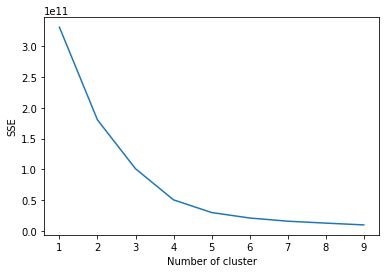

In [26]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,init = 'k-means++', max_iter=1000).fit(y_trainy.values.reshape(-1, 1))
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [27]:
kmeans = KMeans(n_clusters=4,init = 'k-means++', max_iter=1000).fit(y_trainy.values.reshape(-1, 1))
y_train = kmeans.labels_
y_test = kmeans.predict(y_testy.values.reshape(-1, 1))

(array([487.,   0.,   0.,  98.,   0.,   0., 748.,   0.,   0.,  33.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

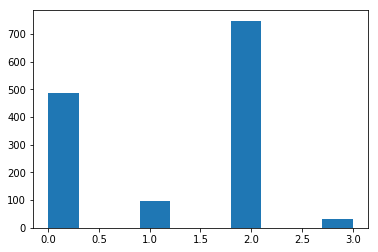

In [28]:
plt.hist(y_train)

In [29]:
centroid = kmeans.cluster_centers_
centroid.sort(axis = 0)
centre = list(centroid.reshape(1,-1)[0])
classe = [(centre[i]+centre[i+1])/2 for i in range(len(centre) - 1)]
print(centre)
print(classe)

[13999.249999999942, 39386.94385026731, 54923.367556468096, 103974.77272727268]
[26693.096925133625, 47155.1557033677, 79449.07014187038]


In [30]:
Y[Y > 79330]

206      104400
345      104400
440      143550
537     94612.5
694      130500
756      104400
780       91350
838      120000
1373     104400
1690     117450
1732     104400
1733      84825
1751     130500
1753     104400
2700      86130
3237      82500
3243     130500
3499     110925
3502      91350
3976      91350
4100      82500
4240     104400
4444     104400
4481     104400
4539     104400
4627     110925
4760      90000
5066     104400
5112     104400
5394     104400
5419     120000
5613     110925
5641     117450
6185     104400
6191     130500
6311      80000
6538      80000
7091      83520
7160     104400
7264     104400
7402     104400
7404     104400
7713      95000
7805     104400
7857     104400
7897     104400
8043     104400
8058     104400
Name: salaire_moyen, dtype: object

In [31]:
s4l4ce = df[df['salaire_moyen'] != 'None']
s4l4ce[s4l4ce['salaire_moyen'] > 79000]

,_id,adresse,date_de_publication,description,localisation,nom_entreprise,salaire,titre,url,salaire_moyen,...,laravel,hololens,docker,jira,scrum,kanban,azure,aws,teamcity,jenkins
206,5da04bf6559bce5541bccf5d,France,2019-09-27 09:30:28.691891,Nous recherchons pour l'un de nos clients gran...,Toulouse,IFEO,300 € - 500 € par jour,Développeur Font End - Freelance H/F,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,104400,...,0,0,0,0,0,0,0,0,0,0
345,5da05a01559bce5541bcd46f,44000 Nantes,2019-09-24 10:03:08.074494,Afin d’accompagner un client un grand compte d...,Nantes,TEAM CONSULTING SARL,300 € - 500 € par jour,Développeur Mobile IOS & ANDROID - REF K - Fre...,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,104400,...,0,0,0,0,0,0,0,0,0,0
440,5da05a01559bce5541bcd4ce,Paris (75),2019-09-10 10:28:49.177515,"Bonjour,\r\nNous recherchons pour notre client...",Paris,Warren Walter,550 € par jour,Développeur double compétence Android/iOS natif,https://www.indeed.fr/company/Warren-walter/jo...,143550,...,0,0,0,0,0,0,0,0,0,0
537,5da05a01559bce5541bcd52f,Paris (75),2019-10-09 11:00:33.236042,"Développeur C# .net (WPF et Winform),\r\n\r\n(...",Paris,WorldWide People,350 € - 375 € par jour,"Développeur C# .net (WPF et Winform), / Freelance",https://www.indeed.fr/rc/clk?jk=5052e9d7232baf...,94612.5,...,0,0,0,0,0,0,0,0,0,0
694,5da05a01559bce5541bcd5ce,Paris (75),2019-10-09 13:39:41.313048,La société :\r\nLe client est un grand acteur ...,Paris,SKILLWISE,500 € par jour,Développeur iOS - H/F / Freelance,https://www.indeed.fr/rc/clk?jk=2984f4b5b953e5...,130500,...,0,0,0,0,1,1,0,0,0,0
756,5da05a01559bce5541bcd60c,69000 Lyon,2019-09-16 11:55:16.631743,"Pour un de nos clients grand-comptes, nous rec...",Lyon,TEAM CONSULTING SARL,300 € - 500 € par jour,Developpeur JAVA - REF AP - Freelance H/F,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,104400,...,0,0,0,0,0,0,0,0,0,0
780,5da05a01559bce5541bcd624,Pessac (33),2019-09-10 12:01:39.948293,Nous sommes à la recherche d’un développeur IO...,Bordeaux,EMGS CONSULTING,350 € par jour,Uregent Développeur IOS Objective-C Swift / Fr...,https://www.indeed.fr/rc/clk?jk=9419b1fc3a8a05...,91350,...,0,0,0,0,1,0,1,0,0,0
838,5da05a01559bce5541bcd65e,Paris (75),2019-09-14 12:24:21.487736,.net core / Azure-cloud-services / Angular / S...,Paris,Blue search conseil,120 000 € par an,CTO/Chief technical officer Digital - H/F,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,120000,...,0,0,0,0,1,0,0,0,0,0
1373,5da05a02559bce5541bcd876,Paris (75),2019-09-23 18:16:08.949577,"Pour un de nos clients grand-comptes, nous rec...",Paris,TEAM CONSULTING SARL,300 € - 500 € par jour,Développeur JAVA 8/ SPRING BOOT - REF K - Free...,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,104400,...,0,0,0,0,0,0,0,0,0,0
1690,5da05a03559bce5541bcd9b3,Arcueil (94),2019-09-19 23:39:16.739633,Développeur CHATBOT.\r\nLieu de prestation Arc...,Paris,WorldWide People,450 € par jour,Développeur CHATBOT. / Freelance,https://www.indeed.fr/rc/clk?jk=f2e6ec01a5ca04...,117450,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df['salaire_moyen']

0        None
1        None
2        None
3        None
4       32000
5        None
6        None
7        None
8        6600
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19      42500
20      40000
21       None
22       None
23      43500
24      37000
25      50000
26      37000
27       None
28       None
29       None
        ...  
8110     None
8111     None
8112     None
8113     None
8114     None
8115     None
8116     None
8117     None
8118     None
8119    57500
8120    42500
8121     None
8122     None
8123     None
8124    55000
8125     None
8126     None
8127    47500
8128     None
8129     None
8130     None
8131     None
8132     None
8133     None
8134     None
8135     None
8136     None
8137     None
8138     None
8139     None
Name: salaire_moyen, Length: 8140, dtype: object

## Régression logistique:

In [57]:
svc = LogisticRegression()
parameters = [{'penalty': ['l2'],'C':[0.001,.006,0.01,0.06,0.1,0.6,1,5,10,25],
              'multi_class':['ovr', 'multinomial'],'class_weight':['balanced', None],
              'solver':['lbfgs','sag','newton-cg'],'max_iter':[1000]},
              {'penalty': ['l1','l2'],'C':[0.001,.006,0.01,0.06,0.1,0.6,1,5,10,25],
              'multi_class':['ovr'],'class_weight':['balanced', None],
              'solver':['liblinear'],'max_iter':[1000]},{'penalty': ['l1','l2'],'C':[0.001,.006,0.01,0.06,0.1,0.6,1,5,10,25],
              'multi_class':['ovr', 'multinomial'],'class_weight':['balanced', None],
              'solver':['saga'],'max_iter':[1000]}]
clf = GridSearchCV(svc, param_grid = parameters, return_train_score=True)
clf.fit(X_train, y_train)
result = pd.DataFrame.from_dict(clf.cv_results_)
#Predict values based on new parameters
y_pred = clf.predict(X_test)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached w

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached w

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached w

In [59]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,param_multi_class,param_penalty,param_solver,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.051668,0.004509,0.003666,4.737338e-04,0.001,balanced,1000,ovr,l2,lbfgs,...,0.665934,0.638767,0.654466,0.011470,153,0.667767,0.669594,0.676535,0.671299,0.003777
1,0.369019,0.015256,0.002983,8.020068e-06,0.001,balanced,1000,ovr,l2,sag,...,0.665934,0.638767,0.655198,0.011779,150,0.667767,0.669594,0.677632,0.671664,0.004285
2,0.141334,0.008179,0.002998,8.214210e-04,0.001,balanced,1000,ovr,l2,newton-cg,...,0.665934,0.638767,0.654466,0.011470,153,0.667767,0.669594,0.676535,0.671299,0.003777
3,0.035001,0.000813,0.002669,4.691232e-04,0.001,balanced,1000,multinomial,l2,lbfgs,...,0.571429,0.561674,0.561493,0.008174,212,0.575358,0.578485,0.592105,0.581983,0.007271
4,0.222003,0.005890,0.002675,4.636720e-04,0.001,balanced,1000,multinomial,l2,sag,...,0.573626,0.561674,0.563690,0.007421,210,0.576458,0.578485,0.588816,0.581253,0.005411
5,0.052666,0.004919,0.002998,8.180923e-04,0.001,balanced,1000,multinomial,l2,newton-cg,...,0.571429,0.561674,0.561493,0.008174,212,0.575358,0.578485,0.592105,0.581983,0.007271
6,0.056994,0.002161,0.003337,4.719885e-04,0.001,None,1000,ovr,l2,lbfgs,...,0.536264,0.537445,0.536603,0.000597,215,0.536854,0.536773,0.536184,0.536604,0.000298
7,0.377344,0.019601,0.003336,4.710411e-04,0.001,None,1000,ovr,l2,sag,...,0.536264,0.537445,0.536603,0.000597,215,0.536854,0.536773,0.536184,0.536604,0.000298
8,0.169999,0.014243,0.003334,4.780224e-04,0.001,None,1000,ovr,l2,newton-cg,...,0.536264,0.537445,0.536603,0.000597,215,0.536854,0.536773,0.536184,0.536604,0.000298
9,0.055668,0.006843,0.003332,4.721573e-04,0.001,None,1000,multinomial,l2,lbfgs,...,0.536264,0.537445,0.536603,0.000597,215,0.536854,0.536773,0.536184,0.536604,0.000298


In [60]:
print(metrics.accuracy_score(y_test, y_pred))
metrics.confusion_matrix(y_test, y_pred)

0.7368421052631579


array([[201,  61,   1,   3],
       [ 42, 104,   1,   0],
       [  2,   1,  12,   0],
       [  8,   1,   0,  19]], dtype=int64)

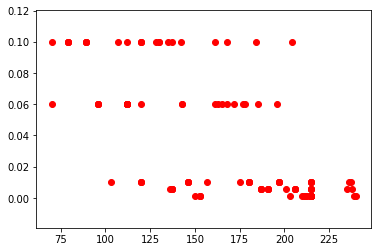

In [68]:
plt.scatter(result['rank_test_score'][result['param_C'] < 0.2],result['param_C'][result['param_C'] < 0.2],color='red')

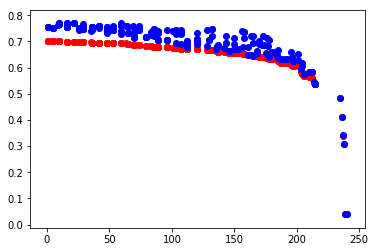

In [111]:
plt.scatter(result['rank_test_score'],result['mean_test_score'],color='red')
plt.scatter(result['rank_test_score'],result['mean_train_score'],color='blue')

## SVM:

In [69]:
model = SVC()
hyperparameters = [
  {'C': [0.1,0.6,1,5,10,25],'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['linear'], 'decision_function_shape': ['ovo', 'ovr']},
  {'C': [0.1,0.6,1,5,10,25], 'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['rbf'], 'decision_function_shape': ['ovo', 'ovr']},
  {'C': [0.1,0.6,1,5,10,25], 'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['poly'], 'degree': [2,3,4,5,6,7],
     'decision_function_shape': ['ovo', 'ovr']},
  {'C': [0.1,0.6,1,5,10,25],'class_weight':['balanced', None],
   'gamma': ['scale','auto'], 'kernel': ['sigmoid'], 'decision_function_shape': ['ovo', 'ovr']}
 ]
clf_SVM = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True)
clf_SVM.fit(X_train, y_train)
result_SVM = pd.DataFrame.from_dict(clf_SVM.cv_results_)
#Predict values based on new parameters
y_pred_SVM = clf_SVM.predict(X_test)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [70]:
print(metrics.accuracy_score(y_test, y_pred_SVM))
metrics.confusion_matrix(y_test, y_pred_SVM)

0.7653508771929824


array([[213,  49,   0,   4],
       [ 37, 108,   1,   1],
       [  2,   1,  12,   0],
       [  6,   6,   0,  16]], dtype=int64)

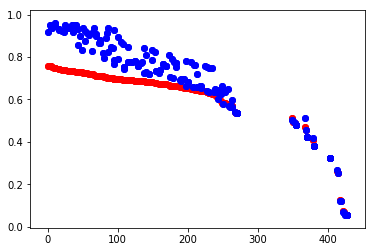

In [71]:
plt.scatter(result_SVM['rank_test_score'],result_SVM['mean_test_score'],color='red')
plt.scatter(result_SVM['rank_test_score'],result_SVM['mean_train_score'],color='blue')

## Random forest:

In [74]:
model = RandomForestClassifier()
hyperparameters = {'n_estimators': [10,50,100,150,200],
                   "criterion": ["gini", "entropy"],
                   "max_depth": [3, 5, None],
                   "min_samples_split": [2, 3, 5, 10],
                   "max_features": ["auto", "sqrt", "log2", None],
                   "bootstrap": [True, False],
                   "class_weight": ["balanced", "balanced_subsample", None]
                  }
clf_RFC = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True)
clf_RFC.fit(X_train, y_train)
result_RFC = pd.DataFrame.from_dict(clf_RFC.cv_results_)
#Predict values based on new parameters
y_pred_RFC = clf_RFC.predict(X_test)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [75]:
print(metrics.accuracy_score(y_test, y_pred_RFC))
metrics.confusion_matrix(y_test, y_pred_RFC)

0.8048245614035088


array([[230,  35,   0,   1],
       [ 37, 109,   1,   0],
       [  2,   1,  12,   0],
       [  6,   6,   0,  16]], dtype=int64)

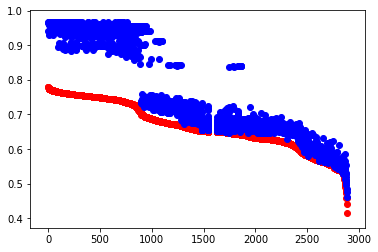

In [76]:
plt.scatter(result_RFC['rank_test_score'],result_RFC['mean_test_score'],color='red')
plt.scatter(result_RFC['rank_test_score'],result_RFC['mean_train_score'],color='blue')

In [77]:
result_RFC

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_split,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.028667,1.700565e-03,0.005009,1.315558e-05,True,balanced,gini,3,auto,2,...,0.512088,0.427313,0.520498,0.079490,2854,0.679868,0.514819,0.510965,0.568551,0.078729
1,0.104048,4.257291e-03,0.014664,4.717101e-04,True,balanced,gini,3,auto,2,...,0.646154,0.656388,0.649341,0.004979,1626,0.688669,0.668496,0.698465,0.685210,0.012477
2,0.201343,3.092894e-03,0.026997,4.331810e-03,True,balanced,gini,3,auto,2,...,0.679121,0.627753,0.656662,0.021431,1408,0.704070,0.684962,0.678728,0.689253,0.010782
3,0.287670,1.461355e-02,0.033346,1.875709e-03,True,balanced,gini,3,auto,2,...,0.661538,0.643172,0.647877,0.009808,1705,0.688669,0.675082,0.701754,0.688502,0.010889
4,0.395322,9.110385e-03,0.045337,2.035189e-03,True,balanced,gini,3,auto,2,...,0.681319,0.654185,0.664714,0.011875,1313,0.691969,0.701427,0.710526,0.701308,0.007576
5,0.026013,8.244310e-04,0.004999,7.370010e-07,True,balanced,gini,3,auto,3,...,0.626374,0.594714,0.543924,0.094864,2775,0.475248,0.603732,0.630482,0.569821,0.067759
6,0.112331,1.188556e-02,0.013994,1.417266e-03,True,balanced,gini,3,auto,3,...,0.668132,0.632159,0.641288,0.019288,1876,0.654565,0.663008,0.683114,0.666896,0.011975
7,0.188002,8.485678e-03,0.023666,4.722133e-04,True,balanced,gini,3,auto,3,...,0.670330,0.676211,0.670571,0.004496,1233,0.693069,0.711306,0.712719,0.705698,0.008949
8,0.302333,2.206932e-02,0.035671,1.251296e-03,True,balanced,gini,3,auto,3,...,0.654945,0.647577,0.652269,0.003322,1466,0.698570,0.684962,0.686404,0.689978,0.006104
9,0.401670,3.364479e-02,0.043663,9.459779e-04,True,balanced,gini,3,auto,3,...,0.672527,0.656388,0.659590,0.009520,1367,0.697470,0.690450,0.712719,0.700213,0.009296


In [112]:
clf_RFC.best_params_

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 150}

In [113]:
clf_RFC.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rfc.fit(X_train, y_train)
# Faire de nouvelles prédictions
y_p = rfc.predict(X_test)
accuracy = metrics.accuracy_score(y_test,y_p)
print("Train:",metrics.accuracy_score(y_train,rfc.predict(X_train)))
print("Test:",accuracy)

Train: 0.95900439238653
Test: 0.8157894736842105


In [52]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble.forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators='warn', criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators

### Features selection:

In [33]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Paris,0.064147
stage_desc,0.054623
freelance_titre,0.043954
e,0.036465
cdi_desc,0.035755
java,0.025828
Lyon,0.024495
angular,0.023825
php,0.021279
react,0.020169


In [64]:
feature_importances['importance'].sum()

0.9999999999999999

(array([151.,  27.,  14.,   5.,   1.,   2.,   1.,   0.,   1.,   1.]),
 array([0.        , 0.00641474, 0.01282948, 0.01924422, 0.02565896,
        0.0320737 , 0.03848844, 0.04490317, 0.05131791, 0.05773265,
        0.06414739]),
 <a list of 10 Patch objects>)

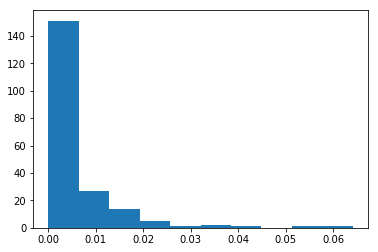

In [51]:
plt.hist(feature_importances['importance'])

In [63]:
moyenne = feature_importances['importance'].mean()
moyenne
feature_importances[feature_importances['importance'] < moyenne].sum()
        
    
    

importance    0.100598
dtype: float64

In [54]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
sel.fit(X_train, y_train)
X_tr = sel.transform(X_train)
X_te = sel.transform(X_test)


(1366, 63)

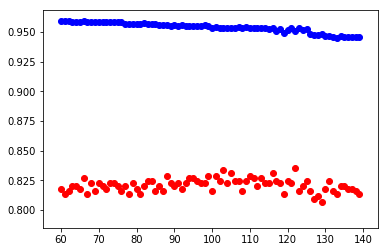

In [76]:
from sklearn.feature_selection import SelectFromModel
liste_accuracy_train = []
liste_accuracy_test = []
mean_percent = list(range(60,140,1))
for i in mean_percent:
    sel = SelectFromModel(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                max_depth=None, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
                oob_score=False, random_state=None, verbose=0,
                warm_start=False),threshold = str(i/100)+'*mean')
    sel.fit(X_train, y_train)
    X_tr = sel.transform(X_train)
    X_te = sel.transform(X_test)
    rfc2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                max_depth=None, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
                oob_score=False, random_state=None, verbose=0,
                warm_start=False)
    rfc2.fit(X_tr, y_train)
    # Faire de nouvelles prédictions
    y_p2 = rfc2.predict(X_te)
    accuracy_test = metrics.accuracy_score(y_test,y_p2)
    accuracy_train =metrics.accuracy_score(y_train,rfc2.predict(X_tr))
    liste_accuracy_test.append(accuracy_test)
    liste_accuracy_train.append(accuracy_train)
    
plt.scatter(mean_percent,liste_accuracy_test, color = 'red')
plt.scatter(mean_percent,liste_accuracy_train, color = 'blue')

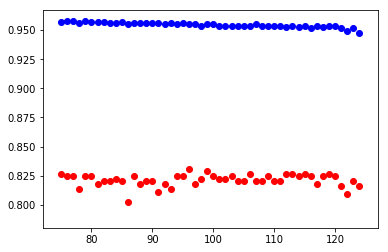

In [75]:
plt.scatter(mean_percent,liste_accuracy_test, color = 'red')
plt.scatter(mean_percent,liste_accuracy_train, color = 'blue')

In [66]:
rfc2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rfc2.fit(X_tr, y_train)
# Faire de nouvelles prédictions
y_p2 = rfc2.predict(X_te)
accuracy = metrics.accuracy_score(y_test,y_p2)
print("Train:",metrics.accuracy_score(y_train,rfc2.predict(X_tr)))
print("Test:",accuracy)

Train: 0.9546120058565154
Test: 0.8179824561403509


In [55]:
X_train.shape

(1366, 203)

In [29]:
X_train.shape

(1366, 203)

In [30]:
y_train.shape

(1366,)

In [ ]:
[DecisionTreeClassifier(max_depth = [1, 5, 10, 15])]

In [33]:
model = AdaBoostClassifier()
hyperparameters = {'base_estimator': [None,
                                      DecisionTreeClassifier(max_depth = 2),
                                      DecisionTreeClassifier(max_depth = 5),
                                      DecisionTreeClassifier(max_depth = 10),
                                      ExtraTreeClassifier(max_depth = 1),
                                      ExtraTreeClassifier(max_depth = 2),
                                      ExtraTreeClassifier(max_depth = 5),
                                      ExtraTreeClassifier(max_depth = 10)
                                      ],                   
                   'n_estimators': [100,150,200,250,300],
                   'learning_rate' : [0.1,0.3],
                   'algorithm' : ['SAMME', 'SAMME.R']
                  }
clf_Ada_tree = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True, error_score='raise')
clf_Ada_tree.fit(X_train, y_train)
result_Ada_tree = pd.DataFrame.from_dict(clf_Ada_tree.cv_results_)
#Predict values based on new parameters
y_pred_Ada_tree = clf_Ada_tree.predict(X_test)
result_Ada_tree.to_csv("result_Ada_tree.csv", index = False)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [34]:
print(metrics.accuracy_score(y_test, y_pred_Ada_tree))
metrics.confusion_matrix(y_test, y_pred_Ada_tree)

0.7872807017543859


array([[103,   1,  40,   1],
       [  4,  18,   6,   0],
       [ 37,   5, 226,   0],
       [  2,   0,   1,  12]], dtype=int64)

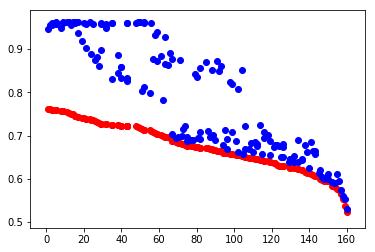

In [35]:
plt.scatter(result_Ada_tree['rank_test_score'],result_Ada_tree['mean_test_score'],color='red')
plt.scatter(result_Ada_tree['rank_test_score'],result_Ada_tree['mean_train_score'],color='blue')

In [39]:
result_Ada_tree[(result_Ada_tree['mean_train_score'] - result_Ada_tree['mean_test_score']) < 0.05].sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_base_estimator,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
13,1.254345,0.167083,0.069677,0.002630,SAMME,"DecisionTreeClassifier(class_weight=None, crit...",0.1,250,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.665208,0.718681,0.676211,0.686676,0.023060,67,0.698570,0.702525,0.707237,0.702777,0.003543
12,0.930001,0.018056,0.055345,0.001237,SAMME,"DecisionTreeClassifier(class_weight=None, crit...",0.1,200,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.671772,0.705495,0.678414,0.685212,0.014588,69,0.686469,0.695939,0.699561,0.693990,0.005520
14,1.382339,0.011667,0.079333,0.000471,SAMME,"DecisionTreeClassifier(class_weight=None, crit...",0.1,300,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.665208,0.709890,0.674009,0.683016,0.019329,70,0.696370,0.691548,0.702851,0.696923,0.004631
54,0.826052,0.060240,0.077670,0.001235,SAMME,"ExtraTreeClassifier(class_weight=None, criteri...",0.1,300,"{'algorithm': 'SAMME', 'base_estimator': Extra...",0.663020,0.683516,0.696035,0.680820,0.013615,72,0.705171,0.692645,0.700658,0.699491,0.005179
58,0.610322,0.002072,0.064683,0.001661,SAMME,"ExtraTreeClassifier(class_weight=None, criteri...",0.3,250,"{'algorithm': 'SAMME', 'base_estimator': Extra...",0.647702,0.690110,0.702643,0.680088,0.023525,73,0.715072,0.722283,0.710526,0.715960,0.004841
59,0.736663,0.013292,0.078656,0.001246,SAMME,"ExtraTreeClassifier(class_weight=None, criteri...",0.3,300,"{'algorithm': 'SAMME', 'base_estimator': Extra...",0.667396,0.670330,0.700441,0.679356,0.014925,74,0.728273,0.708013,0.729167,0.721818,0.009768
19,1.368333,0.035189,0.079334,0.002357,SAMME,"DecisionTreeClassifier(class_weight=None, crit...",0.3,300,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.645514,0.692308,0.691630,0.676428,0.021921,75,0.700770,0.688255,0.702851,0.697292,0.006446
10,0.456677,0.001250,0.028333,0.000472,SAMME,"DecisionTreeClassifier(class_weight=None, crit...",0.1,100,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.663020,0.694505,0.671806,0.676428,0.013270,75,0.684268,0.681668,0.698465,0.688134,0.007382
16,0.680688,0.007747,0.041656,0.001236,SAMME,"DecisionTreeClassifier(class_weight=None, crit...",0.3,150,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.654267,0.681319,0.691630,0.675695,0.015765,77,0.701870,0.669594,0.696272,0.689245,0.014082
11,0.683993,0.001633,0.039341,0.000466,SAMME,"DecisionTreeClassifier(class_weight=None, crit...",0.1,150,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.663020,0.696703,0.665198,0.674963,0.015390,78,0.691969,0.688255,0.691886,0.690703,0.001732


In [37]:
clf_Ada_tree.best_estimator_

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=100, random_state=None)

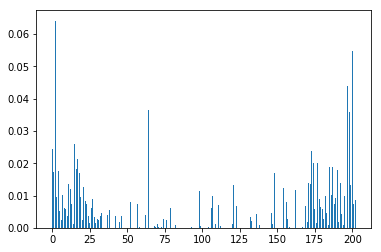

In [50]:
plt.bar(range(len(rfc.feature_importances_)), rfc.feature_importances_)
plt.show()

## Gradient boosting:

In [30]:
model = GradientBoostingClassifier()
hyperparameters = {"loss":["deviance"],
                   "learning_rate": [0.1, 0.3, 0.5],
                   "min_samples_split": [0.1, 0.5, 2],
                   "min_samples_leaf": [0.1, 0.5, 1],
                   "max_depth":[3,5,8],
                   "max_features":["log2","sqrt","auto"],
                   "criterion": ["friedman_mse",  "mae"],
                   "subsample":[0.5, 0.8, 1.0],
                   "n_estimators":[100,150,200,250]
                  }
clf_Gb = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True, error_score='raise',
                      n_jobs=-1)
clf_Gb.fit(X_train, y_train)
result_Gb = pd.DataFrame.from_dict(clf_Gb.cv_results_)
#Predict values based on new parameters
y_pred_Gb = clf_Gb.predict(X_test)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [78]:
help(GradientBoostingClassifier)

Help on class GradientBoostingClassifier in module sklearn.ensemble.gradient_boosting:

class GradientBoostingClassifier(BaseGradientBoosting, sklearn.base.ClassifierMixin)
 |  GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
 |  
 |  Gradient Boosting for classification.
 |  
 |  GB builds an additive model in a
 |  forward stage-wise fashion; it allows for the optimization of
 |  arbitrary differentiable loss functions. In each stage ``n_classes_``
 |  regression trees are fit on the negative gradient of the
 |  binomial or multinomial deviance loss function. Binary classification
 |  is a special case wher

In [80]:
np.linspace(0.1, 0.5, 12)

array([0.1       , 0.13636364, 0.17272727, 0.20909091, 0.24545455,
       0.28181818, 0.31818182, 0.35454545, 0.39090909, 0.42727273,
       0.46363636, 0.5       ])

In [32]:
result_Gb.to_csv("result_Gb.csv", index = False)

In [33]:
result_Gb.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.035000,0.047125,0.009336,0.000469,friedman_mse,0.1,deviance,3,log2,0.1,...,0.580220,0.614537,0.589312,0.018021,3509,0.574257,0.587267,0.615132,0.592219,0.017050
1,1.071336,0.020886,0.014667,0.005251,friedman_mse,0.1,deviance,3,log2,0.1,...,0.628571,0.612335,0.619327,0.006813,3070,0.640264,0.613611,0.656798,0.636891,0.017792
2,0.947000,0.031187,0.012010,0.000830,friedman_mse,0.1,deviance,3,log2,0.1,...,0.652747,0.629956,0.633236,0.014759,2759,0.657866,0.643249,0.654605,0.651907,0.006265
3,1.576327,0.044080,0.017333,0.002357,friedman_mse,0.1,deviance,3,log2,0.1,...,0.615385,0.563877,0.597365,0.023653,3411,0.607261,0.600439,0.604167,0.603955,0.002789
4,1.625997,0.040475,0.015666,0.003858,friedman_mse,0.1,deviance,3,log2,0.1,...,0.657143,0.629956,0.636896,0.014540,2599,0.655666,0.633370,0.667763,0.652266,0.014245


In [35]:
bob = pd.read_csv("result_Gb.csv")
bob.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.035000,0.047125,0.009336,0.000469,friedman_mse,0.1,deviance,3,log2,0.1,...,0.580220,0.614537,0.589312,0.018021,3509,0.574257,0.587267,0.615132,0.592219,0.017050
1,1.071336,0.020886,0.014667,0.005251,friedman_mse,0.1,deviance,3,log2,0.1,...,0.628571,0.612335,0.619327,0.006813,3070,0.640264,0.613611,0.656798,0.636891,0.017792
2,0.947000,0.031187,0.012010,0.000830,friedman_mse,0.1,deviance,3,log2,0.1,...,0.652747,0.629956,0.633236,0.014759,2759,0.657866,0.643249,0.654605,0.651907,0.006265
3,1.576327,0.044080,0.017333,0.002357,friedman_mse,0.1,deviance,3,log2,0.1,...,0.615385,0.563877,0.597365,0.023653,3411,0.607261,0.600439,0.604167,0.603955,0.002789
4,1.625997,0.040475,0.015666,0.003858,friedman_mse,0.1,deviance,3,log2,0.1,...,0.657143,0.629956,0.636896,0.014540,2599,0.655666,0.633370,0.667763,0.652266,0.014245


In [36]:
print(metrics.accuracy_score(y_test, y_pred_Gb))
metrics.confusion_matrix(y_test, y_pred_Gb)

0.793859649122807


array([[109,   0,   0,  36],
       [  6,  13,   0,   9],
       [  2,   0,  12,   1],
       [ 37,   3,   0, 228]], dtype=int64)

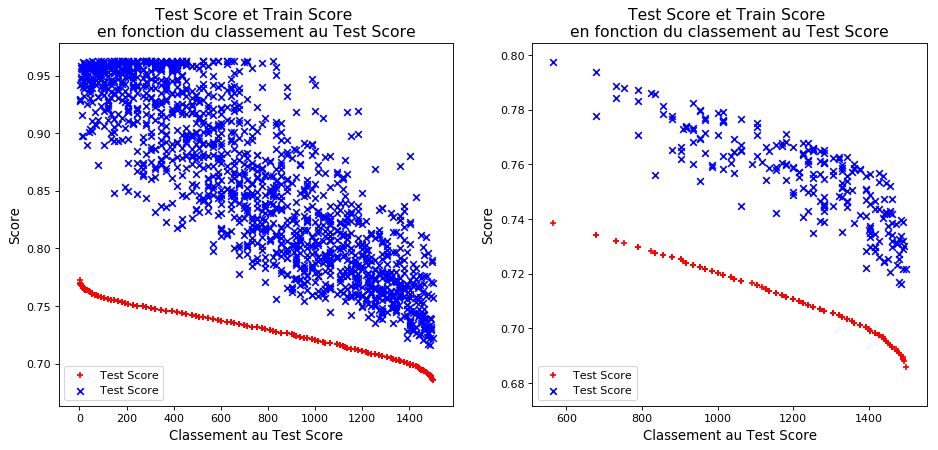

In [66]:
n = 1500
variance = 0.06
result = pd.read_csv("result_Gb.csv")
result_variance = result[(result_Gb['mean_train_score'] - result['mean_test_score']) < variance]

plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)
plt.scatter(result['rank_test_score'][result['rank_test_score'] < n],
            result['mean_test_score'][result['rank_test_score'] < n],color='red',
            marker = "+", label="Test Score")
plt.scatter(result['rank_test_score'][result['rank_test_score'] < n],
            result['mean_train_score'][result['rank_test_score'] < n],color='blue',
            marker = "x", label="Test Score")

plt.title("Test Score et Train Score \nen fonction du classement au Test Score",
          fontsize = 14, loc = 'center')
plt.xlabel("Classement au Test Score",fontsize = 12)
plt.ylabel("Score",fontsize = 12)
plt.legend(loc = 3)

plt.subplot(122)
plt.scatter(result_variance['rank_test_score'][result_variance['rank_test_score'] < n],
            result_variance['mean_test_score'][result_variance['rank_test_score'] < n],color='red',
            marker = "+", label="Test Score")
plt.scatter(result_variance['rank_test_score'][result_variance['rank_test_score'] < n],
            result_variance['mean_train_score'][result_variance['rank_test_score'] < n],color='blue',
            marker = "x", label="Test Score")

plt.title("Test Score et Train Score \nen fonction du classement au Test Score",
          fontsize = 14, loc = 'center')
plt.xlabel("Classement au Test Score",fontsize = 12)
plt.ylabel("Score",fontsize = 12)
plt.legend(loc = 3)
plt.show()

In [52]:
help(plt)

C:\Users\utilisateur\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\utilisateur\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Help on module matplotlib.pyplot in matplotlib:

NAME
    matplotlib.pyplot

DESCRIPTION
    `matplotlib.pyplot` is a state-based interface to matplotlib. It provides
    a MATLAB-like way of plotting.
    
    pyplot is mainly intended for interactive plots and simple cases of programmatic
    plot generation::
    
        import numpy as np
        import matplotlib.pyplot as plt
    
        x = np.arange(0, 5, 0.1)
        y = np.sin(x)
        plt.plot(x, y)
    
    The object-oriented API is recommended for more complex plots.

FUNCTIONS
    acorr(x, *, data=None, **kwargs)
        Plot the autocorrelation of *x*.
        
        Parameters
        ----------
        
        x : sequence of scalar
        
        detrend : callable, optional, default: `mlab.detrend_none`
            *x* is detrended by the *detrend* callable. Default is no
            normalization.
        
        normed : bool, optional, default: True
            If ``True``, input vectors are normalised 

C:\Users\utilisateur\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [38]:
clf_Gb.best_estimator_

GradientBoostingClassifier(criterion='mae', init=None, learning_rate=0.1,
              loss='deviance', max_depth=8, max_features='log2',
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=150, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=0.5, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
result_Gb[result_Gb['rank_test_score']<=10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
319,7.500001,0.099050,0.023998,0.000818,friedman_mse,0.1,deviance,3,auto,1,...,0.778022,0.764317,0.767204,0.007915,9,0.908691,0.891328,0.891447,0.897155,0.008157
647,14.892003,0.504133,0.040332,0.001886,friedman_mse,0.1,deviance,5,auto,1,...,0.767033,0.755507,0.767204,0.009591,9,0.953795,0.953897,0.958333,0.955342,0.002116
745,5.237330,0.241444,0.032670,0.002497,friedman_mse,0.1,deviance,8,log2,1,...,0.784615,0.775330,0.769400,0.015392,3,0.938394,0.927552,0.923246,0.929731,0.006373
858,9.454666,0.170349,0.056667,0.003298,friedman_mse,0.1,deviance,8,sqrt,1,...,0.767033,0.766520,0.768668,0.002675,5,0.955996,0.953897,0.959430,0.956441,0.002281
962,13.652333,0.439923,0.037664,0.004495,friedman_mse,0.1,deviance,8,auto,1,...,0.769231,0.759912,0.767936,0.006074,6,0.954895,0.956092,0.962719,0.957902,0.003441
3663,15.494995,0.064080,0.042672,0.002057,mae,0.1,deviance,8,log2,1,...,0.782418,0.784141,0.772328,0.015460,1,0.932893,0.927552,0.925439,0.928628,0.003137
3670,43.233663,0.594098,0.067337,0.000472,mae,0.1,deviance,8,log2,1,...,0.780220,0.764317,0.767204,0.009658,9,0.949395,0.936334,0.941886,0.942538,0.005352
3671,57.364668,0.566719,0.061669,0.000473,mae,0.1,deviance,8,log2,1,...,0.778022,0.759912,0.767936,0.007531,6,0.952695,0.944018,0.949561,0.948758,0.003588
3769,26.036329,0.494505,0.030001,0.001631,mae,0.1,deviance,8,sqrt,1,...,0.800000,0.759912,0.767204,0.024330,9,0.917492,0.915477,0.914474,0.915814,0.001255
3773,53.081333,0.312794,0.043666,0.002052,mae,0.1,deviance,8,sqrt,1,...,0.791209,0.759912,0.769400,0.015455,3,0.931793,0.919868,0.932018,0.927893,0.005675


In [40]:
result_GB_mean_test_5 = result_Gb[(result_Gb['mean_train_score'] - result_Gb['mean_test_score']) < 0.05]

In [44]:
result_GB_mean_test_5.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
184,2.025332,0.032885,0.025666,0.005314,friedman_mse,0.1,deviance,3,sqrt,1,...,0.747253,0.755507,0.734261,0.024371,678,0.781078,0.773875,0.778509,0.777821,0.002981
302,2.603667,0.025092,0.013666,0.000471,friedman_mse,0.1,deviance,3,auto,1,...,0.749451,0.731278,0.729868,0.016567,788,0.771177,0.771679,0.769737,0.770864,0.000823
193,1.272663,0.017519,0.014668,0.000472,friedman_mse,0.1,deviance,3,sqrt,1,...,0.749451,0.731278,0.727672,0.019387,834,0.765677,0.748628,0.754386,0.756230,0.007081
181,1.368333,0.030944,0.015669,0.000472,friedman_mse,0.1,deviance,3,sqrt,1,...,0.734066,0.740088,0.726208,0.015520,880,0.775578,0.755214,0.765351,0.765381,0.008313
202,3.214999,0.038636,0.026999,0.000002,friedman_mse,0.1,deviance,3,sqrt,1,...,0.736264,0.742291,0.725476,0.019615,902,0.770077,0.760703,0.768640,0.766473,0.004122
197,1.680999,0.008286,0.018333,0.000471,friedman_mse,0.1,deviance,3,sqrt,1,...,0.742857,0.729075,0.725476,0.015837,902,0.772277,0.763996,0.758772,0.765015,0.005560
517,1.440333,0.027354,0.017001,0.000818,friedman_mse,0.1,deviance,5,sqrt,1,...,0.749451,0.733480,0.725476,0.023485,902,0.761276,0.759605,0.765351,0.762077,0.002413
416,2.390668,0.024945,0.029665,0.000944,friedman_mse,0.1,deviance,5,log2,1,...,0.749451,0.726872,0.724744,0.021061,909,0.784378,0.766191,0.768640,0.773070,0.008059
520,2.155001,0.038792,0.024665,0.002493,friedman_mse,0.1,deviance,5,sqrt,1,...,0.747253,0.726872,0.724012,0.020211,917,0.773377,0.767289,0.780702,0.773789,0.005484
736,2.182332,0.012710,0.027999,0.001415,friedman_mse,0.1,deviance,8,log2,1,...,0.747253,0.731278,0.724012,0.022490,917,0.778878,0.770582,0.770833,0.773431,0.003853
